# Yashi Game

Author: Jacopo Magliani

Given a set of n points on a cartesian coordinate system, the Yashi Game consists in connecting all of them with orthogonal lines.

There are some constraints to follow:

- no diagonal lines;

- all the n points must be connected;

- lines cannot cross each other;

- exactly n−1 lines must be used;

- no cycles allowed.


# Basics

First I download the necessaries libraries and packages.

Then I define a function to initialize the game after receiving a dataframe of points and a function that checks if all the points are orthogonally connected.

In [2]:
!pip install python-sat
from pysat.formula import WCNF
from pysat.solvers import Minisat22
from pysat.examples.fm import FM
from itertools import chain
from itertools import combinations
from collections import defaultdict, deque
from io import StringIO
from typing import List, Set, Dict, NewType, Tuple
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import itertools

The dataframe is composed of points (x,y)  e.g. p = (0,1).

A line connects 2 points if they share the same x or y. Each point is connected only to its nearest orthogonal neighbors.

From the dataframe I obtain 3 dictionaries:
- a dictionary of points e.g. {id_point1: (x1, y1), id_point2: (x2, y2)}
- a dictionary of lines e.g. {id_line1: (point1, point2)}
- a dictionary of points-lines connections where the key is a point and its associated value is another dictionary with points connected to it as keys and the lines connecting them as values {point1: {point2_1: line1_1, point3_1: line2_1}}

In [3]:
def init_yashi_game(df):
    #create dictionary of points
    points = dict()
    points=df.set_index(df.columns[0])[[df.columns[1], df.columns[2]]].apply(tuple, axis=1).to_dict()
    #create dictionary of lines
    res = {}
    for _, row in df.iterrows():
      id = row["ID"]
      id_x = df[df["ID"]==id]["X"].values[0]
      id_y = df[df["ID"]==id]["Y"].values[0]
      rows_x = df[df['X'] == id_x] #get points with same x and y of the current node
      rows_x = rows_x[rows_x["ID"]!=id]
      rows_y = df[df['Y'] == id_y]
      rows_y = rows_y[rows_y["ID"]!=id]
      vert=(id_y-rows_x["Y"]) #get the distance of these points from the current node
      hor = (id_x-rows_y["X"])
      down = vert[vert > 0] #distinguish between points over/under/on left/on right of the current node
      up = vert[vert < 0]
      left = hor[hor > 0]
      right = hor[hor < 0]
      result_list = [] #for each direction keep only the closest node
      if not down.empty:
        result_list.append(down.idxmin())
      if not up.empty:
        result_list.append(up.idxmax())
      if not left.empty:
        result_list.append(left.idxmin())
      if not right.empty:
        result_list.append(right.idxmax())
      for i in (result_list): #for each of these nearest points add the tuples (current node, neighbor)
        res[len(res)+1]= (id,i)
    lines = {} #use the obtained dictionary of couples of near points to obtain the dictionary of lines connecting them
    for key, value in res.items(): #for each new couple take the points and update the dictionary
      if value[::-1] not in lines.values():
        lines[key] = value
    lines = {i: value for i, value in enumerate(lines.values(), start=1)}

    #create dictionary of points - lines connections
    pointsToLines = {}
    for line, (point1, point2) in lines.items():
      if point1 not in pointsToLines:
        pointsToLines[point1] = {point2: line}
      else:
        pointsToLines[point1][point2] = line
      if point2 not in pointsToLines:
        pointsToLines[point2] = {point1: line}
      else:
        pointsToLines[point2][point1] = line
    return lines, points, pointsToLines

I define a recursive function that checks if all the points are connected, meaning that starting from the first point we pass thorough all the others by the connecting lines. If the graph is not connected the solver will not start.

In [4]:
def check_connection(points,lines):
  node_0=list(points.keys()).pop(0) #starting point
  visited = [] #list of visited points
  visited.append(node_0)
  visiting = list(lines.values()) #all the point to visit
  visit(node_0,visiting,visited)
  if(len(set(visited))==len(list(points.keys()))):
    return True
  else:
    return False
#recursive function
def visit(node,visiting,visited):
  neighbors = set() #set of neighbors of the current node
  for x, y in visiting: #check all the tuples looking for neighbors of the node e.g. (node,y),(x,node)
    if x == node:
      neighbors.add(y)
    if y == node:
      neighbors.add(x)
  for i in neighbors: #now
    visiting = [t for t in visiting if not (node in t)] #remove the visited tuples from the available tuples
    visited.append(node) #update the visited nodes
    visited.append(i)
  for i in neighbors: #recall the function for the neighbors of the current node
    visit(i,visiting,visited)

# Constraints

The constraints can be defined as: $ϕ = ϕ_{no\_crossing} \land ϕ_{n-1\_lines} \land ϕ_{no\_cycles}$

For the literals I use the line identifiers starting from 1. If for example the lines 1 and 2 cross each other the function that checks this constraint will output [[-1,-2]] meaning that if both the lines are used the clause is not satisfied and will cause unsatisfiability.

If two lines $l_i$ and $l_j$ are crossing I cannot use them together.

$\phi_{no\_crossing} = CNF(\bigwedge_\limits{\substack{l_i,l_j, l_i \neq l_j, \\ iscrossing(l_i, l_j)}} \overline{l_i \land l_j}) = \bigwedge_\limits{\substack{l_i,l_j, l_i \neq l_j, \\ iscrossing(l_i, l_j)}} (\overline{l_i} \lor \overline{l_j})
$.

I find out if two lines are crossing looking at the minimum and maximum coordinates of their points.


In [5]:
#given two lines check if they cross looking at the coordinates of the points connected
def is_crossing(l1, l2, points):
    p1, q1 = points[l1[0]], points[l1[1]]
    p2, q2 = points[l2[0]], points[l2[1]]
    return (
        max(p1[0], q1[0]) > min(p2[0], q2[0]) and
        max(p2[0], q2[0]) > min(p1[0], q1[0]) and
        max(p1[1], q1[1]) > min(p2[1], q2[1]) and
        max(p2[1], q2[1]) > min(p1[1], q1[1])
    )

# Checking if two lines are crossing
def no_crossing(lines, points):
    phi_no_crossing = WCNF() #create hard clause
    items = list(lines.items())
    for index, (l1_id, l1_points) in enumerate(items):
        for l2_id, l2_points in items[index + 1 :]:
            if is_crossing(l1_points, l2_points, points): # if crossing append the clause that forces to not use both of them
                phi_no_crossing.append([-l1_id, -l2_id])
    return phi_no_crossing

The constraint "exactly k" is the conjunction of "at least k" and "at most k"

$\phi_{n-1\_lines} = (\bigwedge_\limits{\substack{I \subseteq [n] \\ |I|=n-k+1}} \bigvee_\limits{i \in I} l_i) \land (\bigwedge_\limits{\substack{I \subseteq [n] \\ |I|=k+1}} \bigvee_\limits{i \in I} \bar{l_i})$

where n is the total number of lines and k of points -1

In [6]:
def exactly_k(lines, points):
    phi_exactly_k = WCNF()
    k = len(points) - 1
    lines_k = lines.keys()
    n = len(lines_k)
    # At least k
    for sub_lits in itertools.combinations(lines_k, n - k + 1):
      phi_exactly_k.append([lit for lit in sub_lits])
    # At most k
    for sub_lits in itertools.combinations(lines_k, k + 1):
      phi_exactly_k.append([-lit for lit in sub_lits])
    return phi_exactly_k

Given a set of cycles made up by some literals of lines, I define the constraint as:

$\phi_{no\_cycles} = CNF(\bigwedge_\limits{c \in C cycles} \overline{\bigwedge_\limits{l \in c} l}) = \bigwedge_\limits{c \in C cycles} \bigvee_\limits{l \in c} \overline{l}$

where I impose to not use all the lines in a cycle at once. The trivial part is there can be multiple cycles and some can be nested inside others.

In [7]:
#function to remove some safe lines from the dictionaries of lines.
def remove_keys_from_secondary_dicts(main_dict, keys_to_remove):
    new_main_dict = {
        main_key: {
            sub_key: sub_value
            for sub_key, sub_value in sub_dict.items() if sub_key not in keys_to_remove
        }
        for main_key, sub_dict in main_dict.items()
    }
    return new_main_dict
#function that returns all possible subset of length >=4
#It is used to try all the possible configurations of trivial lines
def get_subsets(arr):
    subsets = []
    n = len(arr)
    for r in range(4, n + 1):
        for combo in combinations(arr, r):
            subsets.append(list(combo))
    return subsets
#function that uses the tuples of points to determine if they form a cycle e.g. (0,1),(1,2),(2,3),(3,0)
def can_visit_all_tuples(tuples):
    nodes = set()
    for t in tuples:
        nodes.update(t)
    # Create an adjacency list representation of the graph
    graph = {node: [] for node in nodes}
    for t in tuples:
        graph[t[0]].append(t[1])
        graph[t[1]].append(t[0])

    def is_hamiltonian_cycle(node, visited, parent=None, start_node=None):
        visited.add(node)
        for neighbor in graph[node]:
            if neighbor == start_node and len(visited) == len(nodes):
                return True
            if neighbor not in visited and is_hamiltonian_cycle(neighbor, visited, node, start_node):
                return True
        visited.remove(node)
        return False
    return is_hamiltonian_cycle(tuples[0][0], set(), start_node=tuples[0][0])

#function that uses all the previous functions to return all the possible cycles as clauses
def has_cycle(lines,pointsToLines):
  phi_no_cycles = WCNF()
  lines_of_cycles=[] #container of hard clauses
  output_dict = {key: value for key, value in pointsToLines.items() if len(value) > 1} #return the keys of dangerous lines with more than 1 neighbor
  key_to_remove=pointsToLines.keys()-output_dict.keys() #get the safe keys
  dangerous = remove_keys_from_secondary_dicts(output_dict, key_to_remove) #remove the connections with safe lines
  list_of_lists = [list(dv.values()) for dv in dangerous.values()] #get the ids of the dangerous lines
  finals = list(set(item for sublist in list_of_lists for item in sublist)) #and obtain a list of them

  subsets=get_subsets(finals) #obtain all the possible combinations of dangerous lines
  for cand in subsets: #try each possible subset
    values_list = []
    for key in cand: #for each line of the subset get the tuple of points connected to it
      if key in lines:
        values_list.append(lines[key])
    if(can_visit_all_tuples(values_list)): #obtained the list of points, if they form a cycle add the subset to the clause
      lines_of_cycles.append(cand)

  negative_lists = [[-x for x in sublist] for sublist in lines_of_cycles] #prepare the negative literals of the clauses
  for i in negative_lists:
    phi_no_cycles.append(i)
  return phi_no_cycles

This functions checks all the constraints returning a WCNF.

In [8]:
def basic_constraints(lines, points,pointsToLines):
    phi = WCNF()

    phi_no_crossing = no_crossing(lines, points)
    phi_no_cycles = has_cycle(lines,pointsToLines)
    phi_exactly_k = exactly_k(lines, points)

    phi.extend(phi_no_crossing.hard)
    phi.extend(phi_no_cycles.hard)
    phi.extend(phi_exactly_k.hard)

    return phi.hard

# Solvers

The solver first initializes the game and determines if the points are all orthogonally connected. If so it uses hard constraints to search a first solution and store the lines of it, then counts how many total solutions there are.
Then it uses soft constraints to determine the minimum-length solution, where each segment of a line has weight 1.

Then returns the plot of only the points, of the first solution and of the minimum-length solution and how many solutions it has found.

If the points are not connected or there is no solution it sends a message and plots the points.

In [9]:
def minimum_cost_solution_constraints(lines, points, pointsToLines):
    phi = WCNF()
    for (u, v) in lines.values():
        phi.append(
            [pointsToLines[u][v]], weight=-np.linalg.norm(u- v)
        )
    return phi

def existence_solver(df):
    solver = Minisat22()
    lines, points, pointsToLines = init_yashi_game(df) #initialize the game
    maxlen = max(np.max(df["X"]),np.max(df["Y"]))

    if check_connection(points,lines):
      phi_hard = basic_constraints(lines, points,pointsToLines) #hard constraint
      phi_soft = minimum_cost_solution_constraints(lines, points, pointsToLines) #soft constraint
      solver.append_formula(phi_hard)
      solution = solver.solve() #solve hard constraints
      if solution:
          model = solver.get_model()#first solution
          found_lines = {x: lines[x] for x in model if x > 0}#save lines for the plot
          n_sol = 0
          for _ in solver.enum_models(): #count all possible models
            n_sol += 1
          print("Number of solutions: ", n_sol)

      phi = WCNF()#minimum-length solution
      phi.extend(phi_hard)
      phi.extend(phi_soft.soft, weights=phi_soft.wght)
      solver = FM(phi, verbose=0)
      sol = solver.compute() #solve hard and soft constraints
      if sol:
        model = solver.model
        print("Cost of the solution: ", -sum(phi_soft.wght) + solver.cost)
        best_lines = {x: lines[x] for x in model if x > 0}

        #outputs 3 plots
        fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(14, 4))
        fig.suptitle('Yashi Game')
        ax1.scatter(df['X'], df['Y'], c='blue', marker='o')
        ax2.scatter(df['X'], df['Y'], c='blue', marker='o')
        ax3.scatter(df['X'], df['Y'], c='blue', marker='o')
        for i, txt in enumerate(df['ID']):
          ax1.annotate(txt, (df['X'][i], df['Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')
          ax2.annotate(txt, (df['X'][i], df['Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')
          ax3.annotate(txt, (df['X'][i], df['Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')
        for u, v in found_lines.values():
          (x1, y1), (x2, y2) = points[u], points[v]
          ax2.plot([x1, x2], [y1, y2], "k-")
        for u, v in best_lines.values():
          (x1, y1), (x2, y2) = points[u], points[v]
          ax3.plot([x1, x2], [y1, y2], "k-")
        ax1.set_xlim([-1, maxlen+1]),ax1.set_ylim([-1, maxlen+1])
        ax2.set_xlim([-1, maxlen+1]),ax2.set_ylim([-1, maxlen+1])
        ax3.set_xlim([-1, maxlen+1]),ax3.set_ylim([-1, maxlen+1])
        ax1.set_title("Points"),ax2.set_title("Random Solution"),ax3.set_title("Minimum-length Solution")
        ax1.grid(True),ax2.grid(True),ax3.grid(True)

      else:#no solution
        print("No Solution")
        plt.scatter(df['X'], df['Y'], c='blue', marker='o')
        for i, txt in enumerate(df['ID']):
          plt.annotate(txt, (df['X'][i], df['Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')
        plt.xlim([-1, maxlen+1]),plt.ylim([-1, maxlen+1])
        plt.title("Points")
        plt.grid(True)
    else:#not connected
      print("No Connection")
      plt.scatter(df['X'], df['Y'], c='blue', marker='o')
      for i, txt in enumerate(df['ID']):
          plt.annotate(txt, (df['X'][i], df['Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')
      plt.xlim([-1, maxlen+1]),plt.ylim([-1, maxlen+1])
      plt.title("Points")
      plt.grid(True)

# Games

Generate a dataframe of random points in a certain range. Then try to solve it.

In [10]:
def play_random(n_points,range_points):
  tuples = []
  while len(tuples) < n_points:
    new_point = (random.randint(0, range_points), random.randint(0, range_points))
    if new_point not in tuples:
        tuples.append(new_point)
  # Sort the tuples first by x and then by y
  sorted_tuples = sorted(tuples, key=lambda x: (x[0], x[1]))
  df = pd.DataFrame(sorted_tuples, columns=['X', 'Y'])
  df['ID'] = range(n_points)
  df = df[['ID', 'X', 'Y']]
  existence_solver(df)

def play_dataset(df):
  existence_solver(df)

Number of solutions:  80
Cost of the solution:  135.0


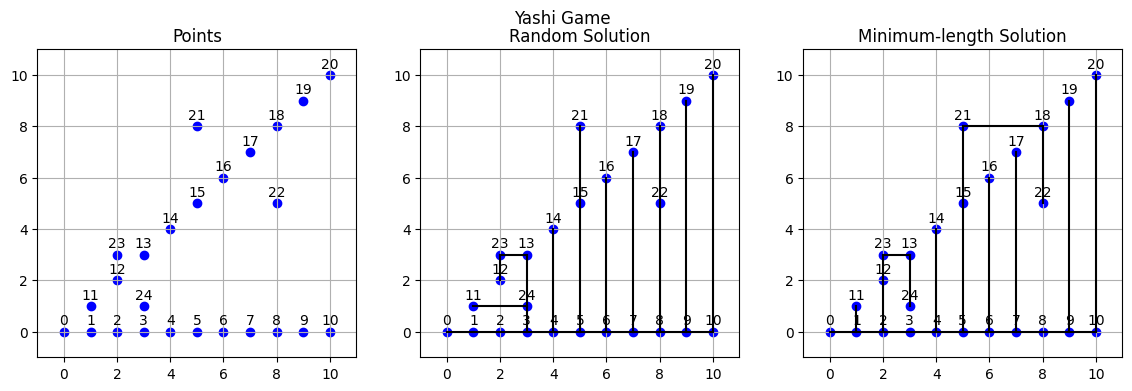

In [31]:
ids=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
x_values=[0,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,5,8,2,3]
y_values=[0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,5,6,7,8,9,10,8,5,3,1]
data = {'ID': ids, 'X': x_values, 'Y': y_values}
df = pd.DataFrame(data)
play_dataset(df)

Number of solutions:  4
Cost of the solution:  15.0


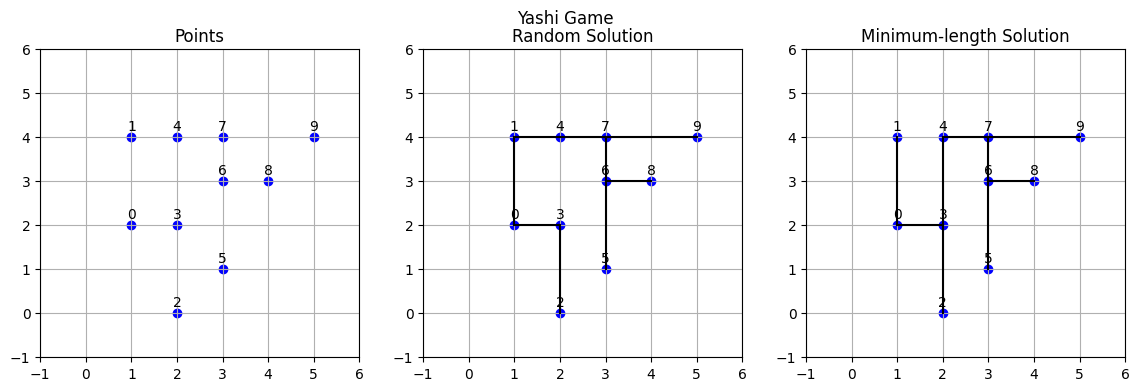

In [41]:
play_random(10,5)

Number of solutions:  4
Cost of the solution:  60.0


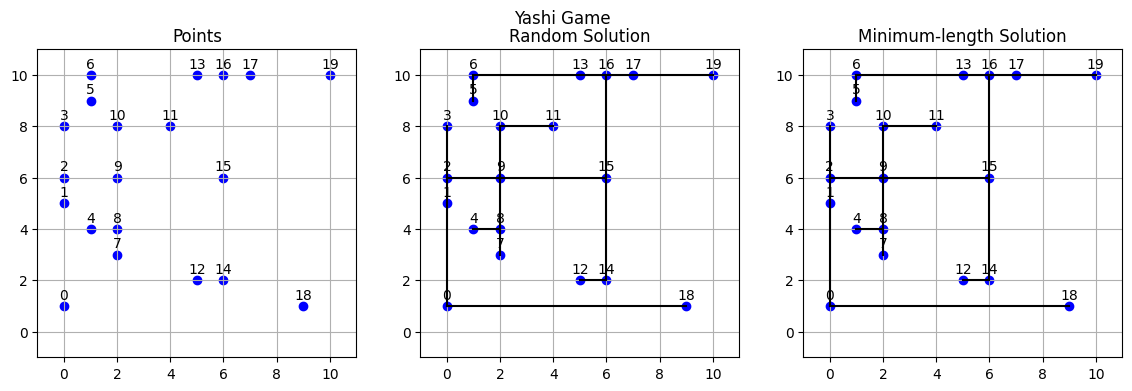

In [46]:
play_random(20,10)